In [1]:
import os
import sys
import numpy as np
import sympy as sp
import torch as pt
from torch.nn.functional import normalize
import scipy
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import logging
import sys
from torch.utils.data import TensorDataset, DataLoader
from torch.func import hessian, vmap
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")

sys.path.append(os.path.abspath('../../'))

from src.useful_functions import *
from src.data_modules.PWDs_module import generate_PWDistances_torch
from src.data_modules.sqra_functions import*
from src.data_modules.openmm_functions import*
from src.isokann.isokann_modules import*
# For reproducibility
np.random.seed(0)


# Read directory paths
read_dirs_paths('../dir_paths_.txt', globals())



 
Created variables:
inp_dir = /scratch/htc/fsafarov/structures/8ef5_july_2025/8ef5/
dcd_dir = /scratch/htc/fsafarov/mOR_dcd_files/npat/
out_dir = /scratch/htc/fsafarov/ISOKANN_PINN/output/


In [2]:
# chi, L_chi = generator_action(base_mlp, x, forces, D)

In [3]:
# psf_file = 'step5_assembly.psf'
# crd_file = 'step5_assembly.crd'

# system, psf, crd = setup_system(
#                     inp_dir,
#                     ligand_name = '7V7',
#                     nbcutoff = 1.0,
#                     psf_file=psf_file,
#                     crd_file=crd_file  
#                 )


# dcd_file = 'mOR_simulation_NPAT_CA_aligned.dcd'
# dt=2.0
# gamma=1.0
# T=310.15
# platform='CUDA'


# forces = get_parameters(
#                         system,
#                         inp_dir,
#                         dcd_file,
#                         dcd_dir,
#                         dt, #in femtoseconds
#                         T,
#                         gamma,
#                         platform,
#                         pdb_file='step5_assembly.pdb',
#                         integrator_type='Langevin',
#                         psf=psf,
#                         get_potential_grad=True
                        
#                       )


In [4]:
# ca_indices = select(psf=psf,selection="protein and name CA")
# # forces_ = np.linalg.norm(forces, axis=-1)

# forces_ = forces[:, ca_indices, :]



In [5]:
# coords = get_parameters(
#                         system,
#                         inp_dir,
#                         dcd_file,
#                         dcd_dir,
#                         dt, #in femtoseconds
#                         T,
#                         gamma,
#                         platform,
#                         pdb_file='step5_assembly.pdb',
#                         integrator_type='Langevin',
#                         psf=psf,
#                         get_coords=True
#                       )

In [6]:
# coords_ = coords[:, ca_indices, :]

In [7]:
# positions = np.linalg.norm(coords, axis=-1)
# positions = positions[:, ca_indices]

In [8]:
# forces_ = pt.Tensor(forces_)
# coords_ = pt.Tensor(coords_)

In [9]:
# pt.save(forces_, os.path.join(out_dir, 'mor_forces_component.pt'))
# pt.save(coords_, os.path.join(out_dir, 'mor_coords.pt'))

In [10]:
# del forces
# del coords

In [11]:
forces = pt.load(os.path.join(out_dir, 'mor_forces_component.pt'))
positions = pt.load(os.path.join(out_dir, 'mor_coords.pt'))
masses = pt.load(os.path.join(out_dir, 'ca_masses.pt'))

positions = positions.reshape(positions.shape[0], -1 )
forces = forces.reshape(forces.shape[0], -1 )
masses = masses.repeat(3)

In [12]:
# mean_forces = forces.mean(dim=-1, keepdim=True)
# std_forces = forces.std(dim=-1, keepdim=True)
# forces_normalized = (forces - mean_forces)/(std_forces + 1e-8)

In [13]:
inp_dim = positions.shape[-1]
nodes = [inp_dim, 256, 128, 64, 1] 
base_mlp = MLP(nodes, act_fun='tanh')

In [14]:
model = ratesNN(base_mlp)
optimizer = pt.optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-5, momentum=0.85, nesterov=True)
# optimizer = pt.optim.Adam([
#     {'params': model.net.parameters(), 'lr': 1e-4},
#     {'params': [model.c1_, model.c2_], 'lr': 1e-3}
# ], weight_decay=1e-5)
# optimizer = pt.optim.SGD([
#     {'params': model.net.parameters(), 'lr': 1e-4},
#     {'params': [model.c1_, model.c2_], 'lr': 1e-3}
# ], weight_decay=1e-5, momentum=0.85, nesterov=True)
# D=2.5                    

c1_vals, c2_vals = trainNN(
    model=model, 
    coords=positions.to(device), 
    forces_fn=forces.to(device), 
    masses=masses.to(device),
    batch_size=500,
    optimizer=optimizer, 
    Nepochs=1000,
    lam_bound=0.1,
    device=device
)

epoch   0 | loss 0.266690 |
epoch 125 | loss 0.002789 |
epoch 250 | loss 0.001338 |
epoch 375 | loss 0.000808 |
epoch 500 | loss 0.000619 |
epoch 625 | loss 0.000440 |
epoch 750 | loss 0.000366 |
epoch 875 | loss 0.000331 |
epoch 1000 | loss 0.000282 |


In [15]:
model.c1

tensor(0.9741, device='cuda:0', grad_fn=<SoftplusBackward0>)

In [16]:
with pt.no_grad():
    chi = model(positions.to(device))


In [17]:
def scale_and_shift(y):
    minarr = pt.min(y)
    maxarr = pt.max(y)
    hat_y =  (y - minarr) / (maxarr - minarr)

    return hat_y

chi_s = scale_and_shift(chi)
chi_s = chi_s.cpu().detach().numpy()

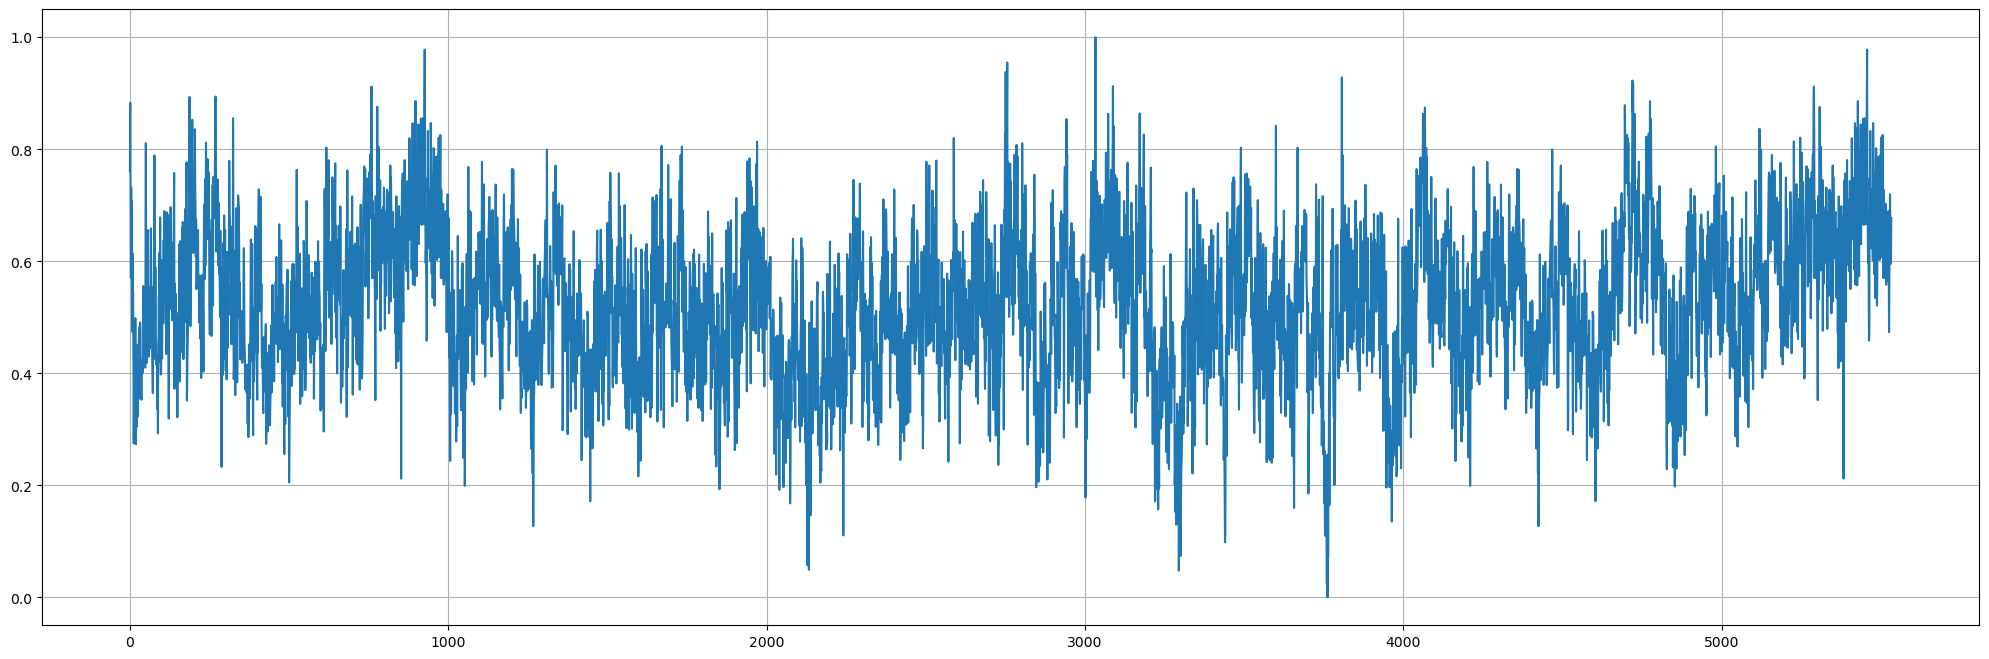

In [18]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(25,8))
plt.plot(chi_s)
plt.grid()

In [19]:
np.savetxt(os.path.join(out_dir, 'chi_mor_0.txt'), chi_s)

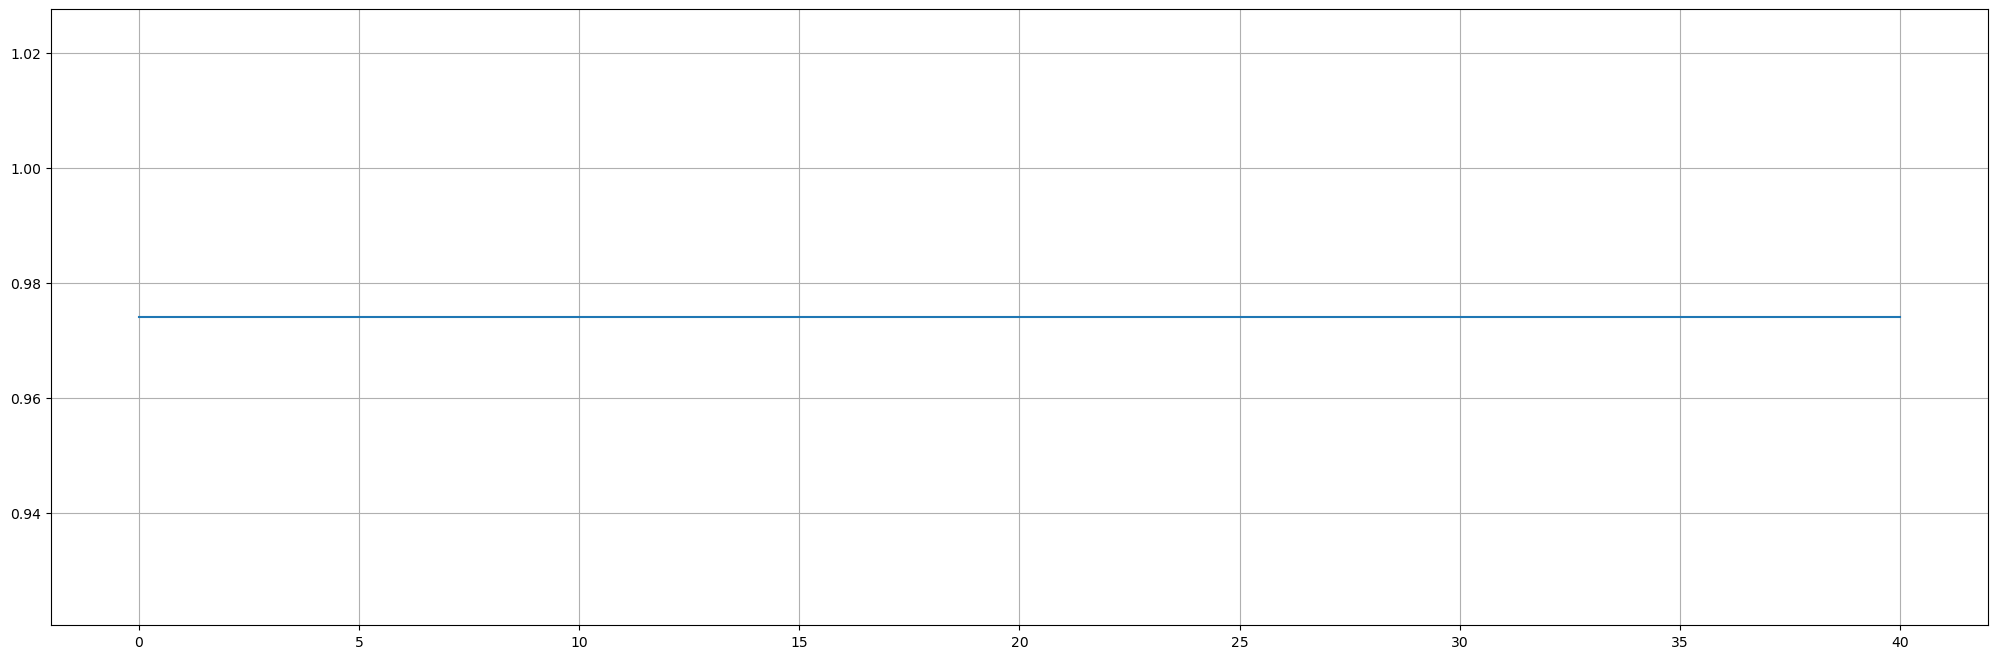

In [20]:
plt.figure(figsize=(25,8))
plt.plot(c2_vals)
plt.grid()

In [21]:
del forces
del positions